# Вариант 7. Толщина кожной складки всех студентов первого курса.

Данные из файла Volgmed_2013.xls (конкретные данные выбрать
в соответствии с вариантом) очистить от выбросов и пропусков, 
построить эмпирическую функцию распределения и гистограмму, 
аппроксимировать одним нормальным, затем смесями двух и трех 
нормальных распределений. 

Вывести плотности распределения полученных аппроксимаций вместе с гистограммой, 
а их функции распределения вместе с эмпирической функцией распределения. 
Для каждой аппроксимации посчитать среднее значение логарифмической функции правдоподобия.

Затем удалить неположительные значения, прологарифмировать
и повторить те же действия, что и с исходными данными.

## Утилиты

### Импорты

In [35]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture

### Константы

In [36]:
DATA_DIR = "data"
FILENAME = "Volgmed_2013.xlsx"
TOL = 1e-6

## Подготовка данных

### Загрузка данных

In [37]:
data_path = Path() / DATA_DIR / FILENAME
df_input = pd.read_excel(data_path, header=1, index_col=0)
df_input.head()

,Пол,Год рождения,Факультет,Курс,Группа,Год поступления,Дата обследования,"Рост, см","Вес, кг","Окружность грудной клетки в покое, см",...,"Гибкость, см","Время 10 хлопков, с","Прыжок в длину с места, см","Челночный бег, с","Силовой норматив, ед","Бег 100 м, с","Бег 2-3 км, мин","Статическая выносливость, с","Задержка дыхания, с","Равновесие, с"
№ п/п,,,,,,,,,,,,,,,,,,,,,
104.0,жен,1981.0,лечебный,1.0,NaN,1999,2000-05-01,176,74.5,90,...,22,6.6,155,26,38,17.7,8.7,140,59.0,90.0
104.0,жен,1981.0,лечебный,3.0,NaN,1999,2002-05-01,176,74,90,...,23,6.5,158,25,47,18.7,6.58,144,68.0,90.0
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Локализация данных

Узнаем какие столбцы присутствуют в данных

In [38]:
df_input.columns

Index(['Пол', 'Год рождения', 'Факультет', 'Курс', 'Группа', 'Год поступления',
       'Дата обследования', 'Рост, см', 'Вес, кг',
       'Окружность грудной клетки в покое, см',
       'Окружность грудной клетки на вдохе, см',
       'Окружность грудной клетки на выдохе, см',
       'Экскурсия грудной клетки, см', 'Толщина кожной складки, мм',
       'Сила правой руки, кг', 'Сила левой руки, кг', 'Становая сила, кг',
       'Гибкость, см', 'Время 10 хлопков, с', 'Прыжок в длину с места, см',
       'Челночный бег, с', 'Силовой норматив, ед', 'Бег 100 м, с',
       'Бег 2-3 км, мин', 'Статическая  выносливость, с',
       'Задержка дыхания, с', 'Равновесие, с'],
      dtype='object')

Выберем студентов первого курса, 
у которых имеется статистика толщины кожной складки

In [39]:
data = df_input[df_input["Курс"] == 1]
data = data["Толщина кожной складки, мм"]
data.reset_index(drop=True, inplace=True)
data

0         16
1       11.5
2        8.5
3       13.5
4       14.5
        ... 
1045       9
1046       8
1047       7
1048       8
1049       6
Name: Толщина кожной складки, мм, Length: 1050, dtype: object

### Подготовка данных

Узнаем количество пропусков

In [40]:
nans = data.isna().sum()
nans

np.int64(15)

Узнаем количество выбросов

In [41]:
q1 = data.quantile(0.25)
q3 = data.quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = data[(data < lower_bound) | (data > upper_bound)]
len(outliers)

37

В сумме имеем $ 37 + 15 = 52 $ неподходящих статистик из $ 1050 $ ($ 4.95 $ %)

Удалим их

In [42]:
data = data.drop(outliers.index).dropna()
data

0         16
1       11.5
2        8.5
3       13.5
4       14.5
        ... 
1045       9
1046       8
1047       7
1048       8
1049       6
Name: Толщина кожной складки, мм, Length: 998, dtype: object

Осталось $ 1050 - 52 = 998 $ подходящих статистик ($ 95.05 $ %)

## Раз два три жопа

Выведем основные графики

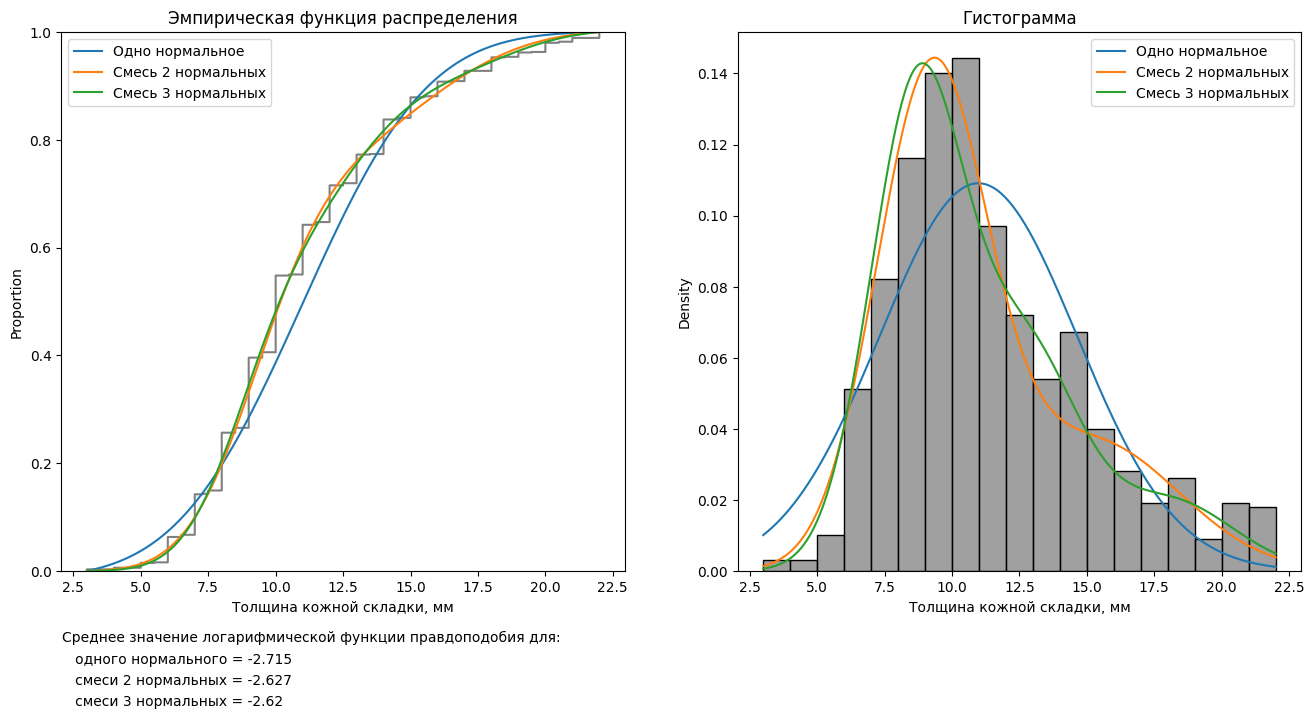

In [191]:
min_stat, max_stat = data.min(), data.max()
x = np.linspace(start=min_stat, stop=max_stat, num=2000)

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.ecdfplot(data, color="gray").set_title("Эмпирическая функция распределения")  # type: ignore

plt.subplot(1, 2, 2)
sns.histplot(data, stat="density", color="gray").set_title("Гистограмма")  # type: ignore

plt.text(
    x=-23, y=-0.02, s="Среднее значение логарифмической функции правдоподобия для: "
)

for n_components in range(1, 4):
    gmm = GaussianMixture(n_components)
    gmm.fit(np.expand_dims(data, 1))

    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]

    label = (
        f"Смесь {n_components} нормальных" if n_components > 1 else "Одно нормальное"
    )

    plt.subplot(1, 2, 1)
    plt.plot(x, cdf, label=label)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, pdf, label=label)
    plt.legend()

    avg_log_likelihood = float(gmm.score(np.expand_dims(data, 1)).round(3))
    text = (
        f"   смеси {n_components} нормальных = "
        if n_components > 1
        else "   одного нормального = "
    ) + str(avg_log_likelihood)

    plt.text(
        x=-23,
        y=-0.02 - 0.006 * n_components,
        s=str(text),
        fontsize=10,
        color="black",
    )

plt.show()

Удалим неположительные значения и прологарифмируем

In [162]:
data = data.astype(float)
data_log = np.log(data[data > 0])
data_log

0       2.772589
1       2.442347
2       2.140066
3       2.602690
4       2.674149
          ...   
1045    2.197225
1046    2.079442
1047    1.945910
1048    2.079442
1049    1.791759
Name: Толщина кожной складки, мм, Length: 998, dtype: float64

Построим те же графики, но на преобразованных данных

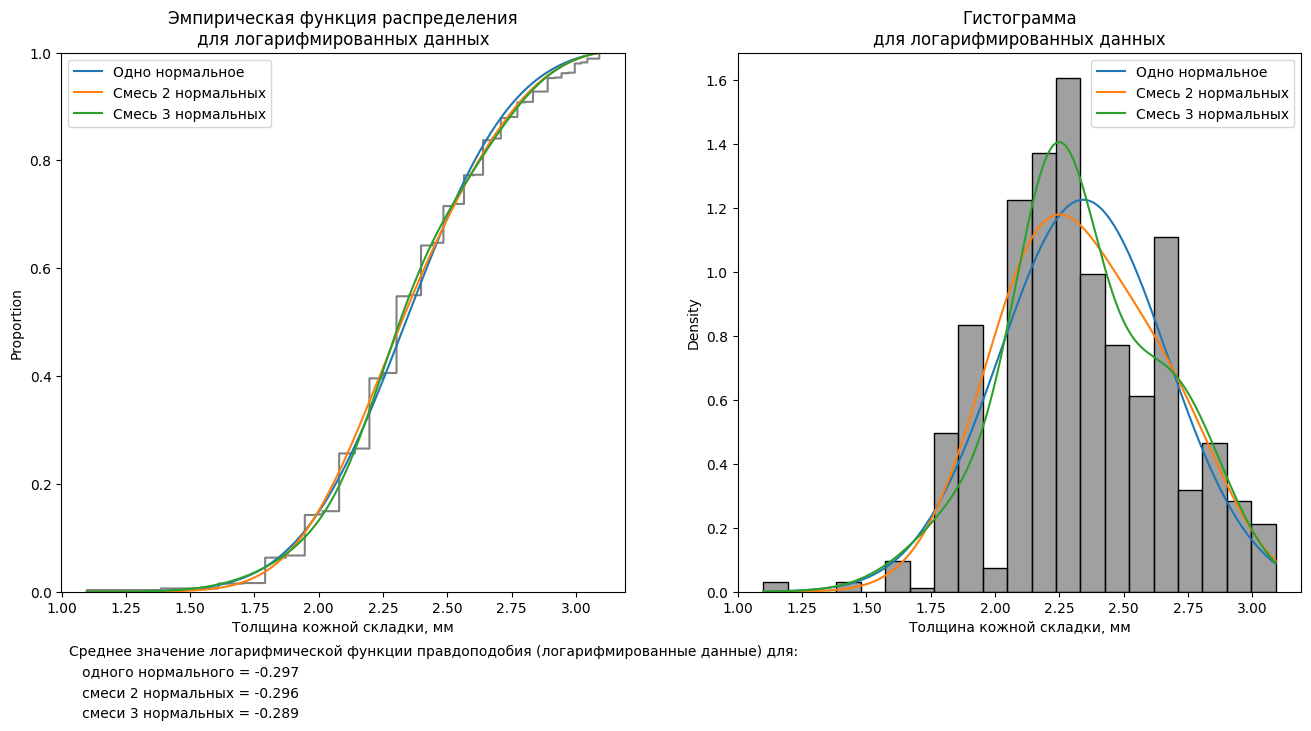

In [195]:
min_stat, max_stat = data_log.min(), data_log.max()
x = np.linspace(start=min_stat, stop=max_stat, num=2000)

plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.ecdfplot(data_log, color="gray").set_title(
    "Эмпирическая функция распределения\nдля логарифмированных данных"
)  # type: ignore

plt.subplot(1, 2, 2)
sns.histplot(data_log, stat="density", color="gray").set_title(
    "Гистограмма\nдля логарифмированных данных"
)  # type: ignore

plt.text(
    x=-1.6,
    y=-0.2,
    s="Среднее значение логарифмической функции правдоподобия (логарифмированные данные) для: ",
)

for n_components in range(1, 4):
    gmm = GaussianMixture(n_components)
    gmm.fit(np.expand_dims(data_log, 1))

    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    cdf = np.cumsum(pdf)
    cdf /= cdf[-1]

    label = (
        f"Смесь {n_components} нормальных" if n_components > 1 else "Одно нормальное"
    )

    plt.subplot(1, 2, 1)
    plt.plot(x, cdf, label=label)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x, pdf, label=label)
    plt.legend()

    avg_log_likelihood = float(gmm.score(np.expand_dims(data_log, 1)).round(3))
    text = (
        f"   смеси {n_components} нормальных = "
        if n_components > 1
        else "   одного нормального = "
    ) + str(avg_log_likelihood)

    plt.text(
        x=-1.6,
        y=-0.2 - 0.065 * n_components,
        s=str(text),
        fontsize=10,
        color="black",
    )

plt.show()